In [35]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt 
import xgboost as xgb

In [2]:
#import datasets
df = pd.read_csv("./spreadspoke_scores.csv")
teams = pd.read_csv("./nfl_teams.csv")

In [3]:
df.shape

(13232, 17)

In [4]:
df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,9/2/1966,1966,1,False,Miami Dolphins,14.0,23.0,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71.0,NaN
1,9/3/1966,1966,1,False,Houston Oilers,45.0,7.0,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70.0,NaN
2,9/4/1966,1966,1,False,San Diego Chargers,27.0,7.0,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82.0,NaN
3,9/9/1966,1966,2,False,Miami Dolphins,14.0,19.0,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78.0,NaN
4,9/10/1966,1966,1,False,Green Bay Packers,24.0,3.0,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62.0,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13232 entries, 0 to 13231
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   schedule_date        13232 non-null  object 
 1   schedule_season      13232 non-null  int64  
 2   schedule_week        13232 non-null  object 
 3   schedule_playoff     13232 non-null  bool   
 4   team_home            13232 non-null  object 
 5   score_home           13231 non-null  float64
 6   score_away           13231 non-null  float64
 7   team_away            13232 non-null  object 
 8   team_favorite_id     10753 non-null  object 
 9   spread_favorite      10753 non-null  float64
 10  over_under_line      10743 non-null  object 
 11  stadium              13232 non-null  object 
 12  stadium_neutral      13232 non-null  bool   
 13  weather_temperature  12189 non-null  float64
 14  weather_wind_mph     12172 non-null  float64
 15  weather_humidity     8441 non-null  

In [6]:
df.schedule_week.unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', 'Conference', 'Superbowl', '17',
       'Division', 'Wildcard', '18', 'WildCard', 'SuperBowl'],
      dtype=object)

In [7]:
# # replacing blank strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# # # removing rows from specific columns that have null values, resetting index and changing data types
df = df[(df.score_home.isnull() == False) & (df.score_away.isnull() == False) &(df.team_favorite_id.isnull() == False)]

df.reset_index(drop=True, inplace=True)

# # # mapping team_id to the correct teams
df['team_home'] = df.team_home.map(teams.set_index('team_name')['team_id'].to_dict())
df['team_away'] = df.team_away.map(teams.set_index('team_name')['team_id'].to_dict())


# # creating home favorite and away favorite columns (fill na with 0's)
df.loc[df.team_favorite_id == df.team_home, 'home_fav'] = 1
df.loc[df.team_favorite_id == df.team_away, 'away_fav'] = 1
df.home_fav.fillna(0, inplace=True)
df.away_fav.fillna(0, inplace=True)


# # stadium neutral and schedule playoff as boolean
df['stadium_neutral'] = df.stadium_neutral.astype(int)
df['schedule_playoff'] = df.schedule_playoff.astype(int)

#coverting named weeks to numerical weeks 
df.loc[(df.schedule_week == 'Wildcard') | (df.schedule_week == 'WildCard'), 'schedule_week'] = '19'
df.loc[(df.schedule_week == 'Division'), 'schedule_week'] = '20'
df.loc[(df.schedule_week == 'Conference'), 'schedule_week'] = '21'
df.loc[(df.schedule_week == 'Superbowl') | (df.schedule_week == 'SuperBowl'), 'schedule_week'] = '22'
df['schedule_week'] = df.schedule_week.astype(int)

# # change data type of date columns
df['schedule_date'] = pd.to_datetime(df['schedule_date'])

In [8]:
df.schedule_week.unique()

array([22,  1, 19, 20, 21,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10752 entries, 0 to 10751
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   schedule_date        10752 non-null  datetime64[ns]
 1   schedule_season      10752 non-null  int64         
 2   schedule_week        10752 non-null  int32         
 3   schedule_playoff     10752 non-null  int32         
 4   team_home            10752 non-null  object        
 5   score_home           10752 non-null  float64       
 6   score_away           10752 non-null  float64       
 7   team_away            10752 non-null  object        
 8   team_favorite_id     10752 non-null  object        
 9   spread_favorite      10752 non-null  float64       
 10  over_under_line      10680 non-null  object        
 11  stadium              10752 non-null  object        
 12  stadium_neutral      10752 non-null  int32         
 13  weather_temperature  9939 non-n

In [10]:
#checking for null values
df.isnull().sum(axis=0)

schedule_date             0
schedule_season           0
schedule_week             0
schedule_playoff          0
team_home                 0
score_home                0
score_away                0
team_away                 0
team_favorite_id          0
spread_favorite           0
over_under_line          72
stadium                   0
stadium_neutral           0
weather_temperature     813
weather_wind_mph        830
weather_humidity       4400
weather_detail         8089
home_fav                  0
away_fav                  0
dtype: int64

In [11]:
df.columns

Index(['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home', 'score_away', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line', 'stadium',
       'stadium_neutral', 'weather_temperature', 'weather_wind_mph',
       'weather_humidity', 'weather_detail', 'home_fav', 'away_fav'],
      dtype='object')

In [12]:
df = df.drop(columns=['spread_favorite', 'over_under_line','weather_detail', 'weather_humidity'])
df = df.drop_duplicates()
df = df.dropna(how='any',axis=0) 

In [13]:
df.isnull().sum(axis=0)

schedule_date          0
schedule_season        0
schedule_week          0
schedule_playoff       0
team_home              0
score_home             0
score_away             0
team_away              0
team_favorite_id       0
stadium                0
stadium_neutral        0
weather_temperature    0
weather_wind_mph       0
home_fav               0
away_fav               0
dtype: int64

In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
schedule_season,9922.0,2000.031748,11.859206,1966.0,1990.0,2001.0,2010.0,2021.0
schedule_week,9922.0,9.268897,5.114106,1.0,5.0,9.0,14.0,22.0
schedule_playoff,9922.0,0.016529,0.127504,0.0,0.0,0.0,0.0,1.0
score_home,9922.0,22.666801,10.385263,0.0,16.0,22.0,30.0,62.0
score_away,9922.0,19.978230,10.062587,0.0,13.0,20.0,27.0,59.0
stadium_neutral,9922.0,0.007660,0.087189,0.0,0.0,0.0,0.0,1.0
weather_temperature,9922.0,59.939931,15.437079,-6.0,50.0,64.0,72.0,97.0
weather_wind_mph,9922.0,7.206511,5.751952,0.0,0.0,7.0,11.0,40.0
home_fav,9922.0,0.663878,0.472405,0.0,0.0,1.0,1.0,1.0
away_fav,9922.0,0.321810,0.467194,0.0,0.0,0.0,1.0,1.0


In [15]:
#creating binary tagret variable HTW(Home Team Win)
df['HTW'] = (df.score_home > df.score_away).astype(int)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9922 entries, 0 to 10751
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   schedule_date        9922 non-null   datetime64[ns]
 1   schedule_season      9922 non-null   int64         
 2   schedule_week        9922 non-null   int32         
 3   schedule_playoff     9922 non-null   int32         
 4   team_home            9922 non-null   object        
 5   score_home           9922 non-null   float64       
 6   score_away           9922 non-null   float64       
 7   team_away            9922 non-null   object        
 8   team_favorite_id     9922 non-null   object        
 9   stadium              9922 non-null   object        
 10  stadium_neutral      9922 non-null   int32         
 11  weather_temperature  9922 non-null   float64       
 12  weather_wind_mph     9922 non-null   float64       
 13  home_fav             9922 non-nu

<AxesSubplot:>

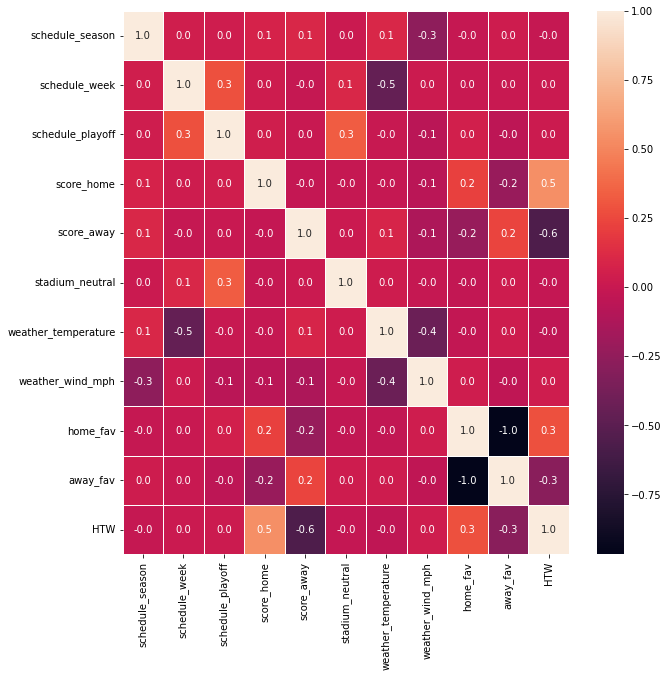

In [17]:
a,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [18]:
df_final = df.drop(columns=['schedule_date','score_home','score_away','stadium','away_fav','team_home','team_away','team_favorite_id'])

In [19]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9922 entries, 0 to 10751
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   schedule_season      9922 non-null   int64  
 1   schedule_week        9922 non-null   int32  
 2   schedule_playoff     9922 non-null   int32  
 3   stadium_neutral      9922 non-null   int32  
 4   weather_temperature  9922 non-null   float64
 5   weather_wind_mph     9922 non-null   float64
 6   home_fav             9922 non-null   float64
 7   HTW                  9922 non-null   int32  
dtypes: float64(3), int32(4), int64(1)
memory usage: 542.6 KB


In [20]:
X = df_final.loc[:, df_final.columns != 'HTW']
y = df_final.loc[:, df_final.columns == 'HTW']

In [21]:
#feature selection

logreg = LogisticRegression()
rfe = RFE(logreg,n_features_to_select=5)
rfe = rfe.fit(X, y)
print(rfe.support_)
print(rfe.ranking_)

[False False  True  True  True  True  True]
[3 2 1 1 1 1 1]


D:\New folder\envs\rstudio-\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\New folder\envs\rstudio-\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\New folder\envs\rstudio-\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
for i in range(X.shape[1]):
    
    print('Column: %s, Selected %s, Rank: %.3f' % (X.columns.to_list()[i], rfe.support_[i], rfe.ranking_[i]))

Column: schedule_season, Selected False, Rank: 3.000
Column: schedule_week, Selected False, Rank: 2.000
Column: schedule_playoff, Selected True, Rank: 1.000
Column: stadium_neutral, Selected True, Rank: 1.000
Column: weather_temperature, Selected True, Rank: 1.000
Column: weather_wind_mph, Selected True, Rank: 1.000
Column: home_fav, Selected True, Rank: 1.000


In [23]:
X.columns

Index(['schedule_season', 'schedule_week', 'schedule_playoff',
       'stadium_neutral', 'weather_temperature', 'weather_wind_mph',
       'home_fav'],
      dtype='object')

In [24]:
cols = ['schedule_week', 'schedule_playoff',
       'stadium_neutral', 'weather_temperature', 'weather_wind_mph',
       'home_fav']
X = X[cols]

In [25]:
#spliting the dataset into test and train 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

D:\New folder\envs\rstudio-\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [26]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test,y_test)))
accuracy_score(y_test, y_pred)

Accuracy of logistic regression classifier on test set: 0.68


0.6785894206549118

In [27]:

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[434 382]
 [256 913]]


In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.53      0.58       816
           1       0.71      0.78      0.74      1169

    accuracy                           0.68      1985
   macro avg       0.67      0.66      0.66      1985
weighted avg       0.67      0.68      0.67      1985



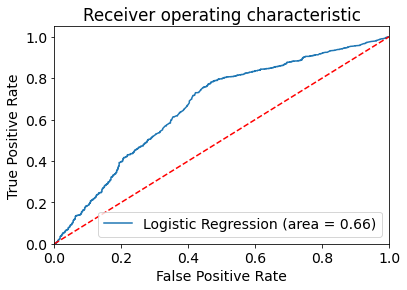

In [29]:

plt.rc("font", size=14)

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [30]:
gNB = GaussianNB()
gNB.fit(X_train, y_train)

D:\New folder\envs\rstudio-\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [31]:
y_pred_gNB = gNB.predict(X_test)
print('Accuracy of Guassian Navies Base classifier on test set: {:.2f}'.format(gNB.score(X_test, y_test)))

Accuracy of Guassian Navies Base classifier on test set: 0.68


In [36]:
confusion_matrix_GNB = confusion_matrix(y_test, y_pred_gNB)
print(confusion_matrix_GNB)

[[433 383]
 [253 916]]


In [33]:
print(classification_report(y_test, y_pred_gNB))

              precision    recall  f1-score   support

           0       0.63      0.53      0.58       816
           1       0.71      0.78      0.74      1169

    accuracy                           0.68      1985
   macro avg       0.67      0.66      0.66      1985
weighted avg       0.67      0.68      0.67      1985



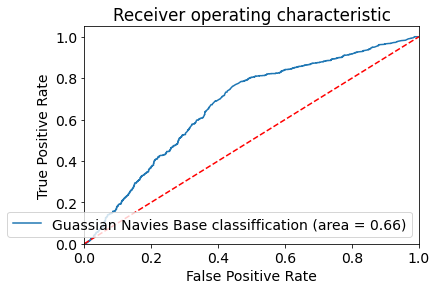

In [34]:
plt.rc("font", size=14)

gNB_roc_auc = roc_auc_score(y_test, gNB.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gNB.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Guassian Navies Base classiffication (area = %0.2f)' % gNB_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [37]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [42]:
y_pred_xgb = xgb_cl.predict(X_test)
print('Accuracy of Guassian Navies Base classifier on test set: {:.2f}'.format(xgb_cl.score(X_test, y_test)))
print(classification_report(y_test, y_pred_xgb))

Accuracy of Guassian Navies Base classifier on test set: 0.65
              precision    recall  f1-score   support

           0       0.59      0.51      0.55       816
           1       0.69      0.76      0.72      1169

    accuracy                           0.65      1985
   macro avg       0.64      0.63      0.63      1985
weighted avg       0.65      0.65      0.65      1985



In [39]:
confusion_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print(confusion_matrix_xgb)

[[413 403]
 [284 885]]


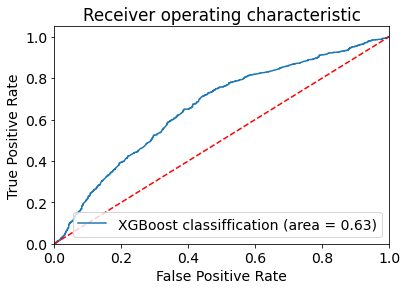

In [41]:
plt.rc("font", size=14)

xGB_roc_auc = roc_auc_score(y_test, xgb_cl.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb_cl.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost classiffication (area = %0.2f)' % xGB_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()